<a href="https://colab.research.google.com/github/ZeshanRasul/LSTM_Sentiment_Analysis/blob/main/LSTM_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook is a project on using LSTM neural networks for sentiment analysis of tweets to appropriately decide whether a tweet is hateful or not.

In [ ]:
# Twitter dataset available at https://www.kaggle.com/datasets/arkhoshghalb/twitter-sentiment-analysis-hatred-speech

In [ ]:
!unzip train.csv.zip

Archive:  train.csv.zip
  inflating: train.csv               


Reading our dataset with pandas and we can see that each example  has a label of 0 if the sentiment is not hatred or 1 if the sentiment is hatred.

In [ ]:
import pandas as pd

train_df = pd.read_csv('train.csv')

train_df

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation
...,...,...,...
31957,31958,0,ate @user isz that youuu?ðððððð...
31958,31959,0,to see nina turner on the airwaves trying to...
31959,31960,0,listening to sad songs on a monday morning otw...
31960,31961,1,"@user #sikh #temple vandalised in in #calgary,..."


Checking the example count for each label we can see this is an imbalanced dataset where there are many more examples that are labelled as not hatred compared to the number of examples labelled as hatred.



In [ ]:
train_df['label'].value_counts()

,count
label,
0,29720
1,2242


We will use the Stanford GloVe embedding vectors to represent the words from the tweets into vector form that can be used with our model.

In [ ]:
!wget http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip

--2025-02-24 18:05:55--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  5.24MB/s    in 2m 40s  

2025-02-24 18:08:35 (5.15 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]



In [ ]:
!unzip glove.6B.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


We will use Numpy and the GloVe embedding vectors to create a Python dictionary that will contain a mapping of each of the words in our training set to a word embedding vector. In this case we will use 50d vectors.

In [ ]:
import numpy as np

words = dict()

def add_to_dict(d, filename):
  with open(filename, 'r') as f:
    for line in f.readlines():
      line = line.split(' ')

      try:
        d[line[0]] = np.array(line[1:], dtype=float)
      except:
        continue

The `add_to_dict` function takes a parameter `d` for our dictionary and a the filename with the GloVe word embeddings.

In [31]:
add_to_dict(words, 'glove.6B.50d.txt')

`words` is a dictionary holding key value pairs where the key is a particular word consisting of characters and the value is a Numpy array for the word embedding vector.

The Stanford GloVe word embeddings provide us vector representations for 400,000 words

In [ ]:
len(words)

400000

Next we will import the popular Python NLTK library for some common NLP tasks

In [ ]:
import nltk

nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

We will need to tokenize our text in order to break it up into suitable chunks to be processed by our model. We will use the NLTK Regular Expression Tokenizer for this. We will tokenize our tweet text into individual words.

In [ ]:
tokenizer = nltk.RegexpTokenizer(r"\w+")

We will also need to lemmatize each word. This simply means reducing a word into its root form (also known as its *lemma*). We will again use NLTK for this process.

In [ ]:
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

We will use the following function `message_to_tokens` to tokenize a tweet, convert each token to lower case, lemmatize the token and then return all tokens that we have embedding vectors for.

In [ ]:
def message_to_token_lists(s):
  tokens = tokenizer.tokenize(s)
  lowercase_tokens = [t.lower() for t in tokens]
  lemmatized_tokens = [lemmatizer.lemmatize(t) for t in lowercase_tokens]
  useful_tokens = [t for t in lemmatized_tokens if t in words]
  return useful_tokens

Our next step is to create a list of embedding vectors where each element of the list represents the word embedding for a token in our `useful_tokens` list.

In [ ]:
def message_to_word_vectors(message, word_dict=words):
  processed_token_list = message_to_token_lists(message)

  vectors = []

  for token in processed_token_list:
    if token not in word_dict:
      continue

    token_vector = word_dict[token]
    vectors.append(token_vector)

  return np.array(vectors, dtype=float)

Next we need to split our training dataframe into an `X` and `y` array, with `X` holding the tweet in word vector form and `y` holding the related label, either 0 or 1 based on whether the tweet contains hatred or not.

In [ ]:
def df_to_X_y(pd_df):
  y = pd_df['label'].to_numpy().astype('int')

  all_word_vector_sequences = []

  for message in pd_df['tweet']:
    message_as_vector_sequence = message_to_word_vectors(message)

    if message_as_vector_sequence.shape[0] == 0:
      message_as_vector_sequence = np.zeros(shape=(1, 50))

    all_word_vector_sequences.append(message_as_vector_sequence)

  return all_word_vector_sequences, y

Currently, we can't use this function to directly create a Numpy array of word vector sequences. This is because the sequences for each example are not all the same length.

To fix this we can first perform some simply analysis to understand the range of sequence length values and use the maximum length of a sequence. Using the maximum length we can pad shorter sequences and then create a Numpy array where all the sequences are the maximum length.



(array([5.002e+03, 9.964e+03, 9.703e+03, 5.363e+03, 1.791e+03, 1.190e+02,
        1.300e+01, 1.000e+00, 1.000e+00, 5.000e+00]),
 array([ 1. ,  6.5, 12. , 17.5, 23. , 28.5, 34. , 39.5, 45. , 50.5, 56. ]),
 <BarContainer object of 10 artists>)

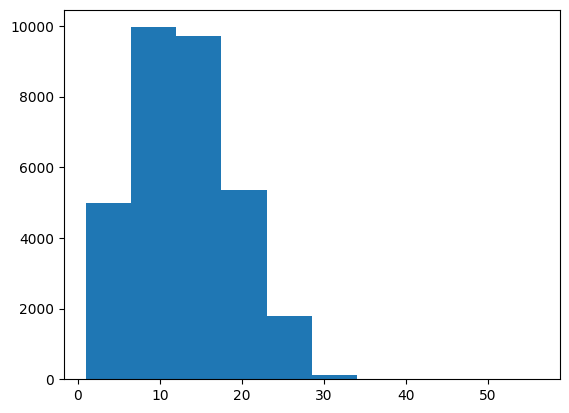

In [ ]:
X, y = df_to_X_y(train_df)

sequence_lengths = []

for i in range(len(X)):
  sequence_lengths.append(len(X[i]))

import matplotlib.pyplot as plt

plt.hist(sequence_lengths)

The above shows us the distribution of sequence lengths which correspond to the number of words in a given tweet. The majority are approximately between 8 and 18 words with a few outliers around 30 words and a very small number reaching approximately 50 words.

We can use Pandas for further analytical investigation below.

In [ ]:
pd.Series(sequence_lengths).describe()

,0
count,31962.000000
mean,12.680840
std,5.924605
min,1.000000
25%,8.000000
50%,12.000000
75%,17.000000
max,56.000000


Here we can see more precisely, that the average message length is approximately 12 words long, with the shortest being 1 word and the maximum being 56 words. Looking at the quartile breakdown, 75% of the sequences are 17 words or less.

These findings allow us to create a padding function which can pad the dimensions of our `X` message word vectors to all have a minimum length.

Given the largest word vector sequence is 56 useful tokens long, we can use 57 as the desired sequence length, padding the word vector with zeros to give it a length of 57.

In [ ]:
from copy import deepcopy

def pad_X(X_to_pad, desired_sequence_length=57):
  X_copy = deepcopy(X_to_pad)

  for i, x in enumerate(X_to_pad):
    sequence_length = x.shape[0]
    sequence_length_diff = desired_sequence_length - sequence_length

    pad = np.zeros(shape=(sequence_length_diff, 50))

    X_copy[i] = np.concatenate([x, pad])

  return np.array(X_copy).astype(float)

Now we can pad our `X` array and split our dataset into a training set, cross-validation set and test  which can be done with sklearn. We also need to split the target value labels out of the training set to use when training and evaluating our model.

In [ ]:
from sklearn.model_selection import train_test_split

X = pad_X(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=49)

X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=49)

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((19177, 57, 50), (19177,), (6392, 57, 50), (6392,), (6393, 57, 50), (6393,))

We can see from the lengths of each array, the training data has been split into a 60:20:20 ratio of training examples, cross-validation examples and test examples. Each set has the same number of examples, `X` as target labels `y`.

Also we can see our zero padding has been correctly applied, with each word vector having a length of 57, with 50 floats per vector, corresponding to the embeddings for that word.

We can now start building our model using Tensorflow. We will build a sequential LSTM model for this sentiment analysis task. Dropout layers will be used for regularisation to prevent the model
from overfitting to training data and making it more likely to generalise to new, unseen examples.

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

model = Sequential([])

model.add(layers.Input(shape=(57, 50)))
model.add(layers.LSTM(64, return_sequences=True))
model.add(layers.Dropout(0.2))
model.add(layers.LSTM(64, return_sequences=True))
model.add(layers.Dropout(0.2))
model.add(layers.LSTM(64, return_sequences=True))
model.add(layers.Dropout(0.2))
model.add(layers.Flatten())
model.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 57, 64)              │          29,440 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 57, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 57, 64)              │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 57, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 57, 64)              │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 57, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 3648)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │           3,649 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 99,137 (387.25 KB)

 Trainable params: 99,137 (387.25 KB)

 Non-trainable params: 0 (0.00 B)

Now that we have constructed our LSTM neural network we can setup the model compilation with our loss function and optimiser as well as some other details.

We will use BinaryCrossentropy as our loss function as this task is an example of binary classification. In other words, our model will predict one of two possible values, either 1 if the message contains hatred and 0 if the message does not contain hatred.

In [ ]:
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint('model/best_model.keras', save_best_only=True)

model.compile(optimizer=Adam(learning_rate=0.001),
              loss=BinaryCrossentropy(),
              metrics=['accuracy', AUC(name='auc')])

We saw earlier that the training set is imbalanced, with a large number of negative examples with a label of 0 and a much smaller number of positive examples with a label of 1. To improve the performance of our model given this imbalance in training examples, we will adjust the computed weights according to the ratio of total examples to the number of examples of each label value.

In [ ]:
frequencies = pd.value_counts(train_df['label'])
frequencies

<ipython-input-26-2898d919e8c2>:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  frequencies = pd.value_counts(train_df['label'])


,count
label,
0,29720
1,2242


In [ ]:
weights = {0: frequencies.sum() / frequencies[0], 1: frequencies.sum() / frequencies[1]}
weights

{0: 1.0754374158815612, 1: 14.256021409455842}

We are now ready to train our model!

In [ ]:
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, callbacks=[checkpoint], class_weight=weights)

Epoch 1/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 17s 15ms/step - accuracy: 0.7661 - auc: 0.8251 - loss: 1.0356 - val_accuracy: 0.8148 - val_auc: 0.8942 - val_loss: 0.3903
Epoch 2/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 17s 17ms/step - accuracy: 0.8159 - auc: 0.9103 - loss: 0.7840 - val_accuracy: 0.8636 - val_auc: 0.9088 - val_loss: 0.3478
Epoch 3/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.8371 - auc: 0.9266 - loss: 0.6995 - val_accuracy: 0.7550 - val_auc: 0.9147 - val_loss: 0.5442
Epoch 4/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.8433 - auc: 0.9320 - loss: 0.6774 - val_accuracy: 0.8354 - val_auc: 0.9213 - val_loss: 0.3755
Epoch 5/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - accuracy: 0.8620 - auc: 0.9522 - loss: 0.5668 - val_accuracy: 0.8609 - val_auc: 0.9214 - val_loss: 0.3188
Epoch 6/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.8723 - auc: 0.9521 - loss: 0.5481 - val_accuracy: 0.8908 - val_auc: 0.9280 - val_loss: 0.2771
Epoch 7/20
600/600 ━━━━━━━━━━

After training, we can use our model on the test set to make predictions on unseen data and see how well our model performs.

We load our best model that was saved by our Tensorflow callback and use sklearn to evaluate our models classification performance.

In [ ]:
from tensorflow.keras.models import load_model

best_model = load_model('model/best_model.keras')

In [ ]:
test_predictions = (best_model.predict(X_test) > 0.5).astype(int)

from sklearn.metrics import classification_report

print(classification_report(y_test, test_predictions))

200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
              precision    recall  f1-score   support

           0       0.98      0.94      0.96      5974
           1       0.49      0.75      0.59       419

    accuracy                           0.93      6393
   macro avg       0.74      0.85      0.78      6393
weighted avg       0.95      0.93      0.94      6393



## Results Analysis

The classification report highlights the strengths and weaknesses of the LSTM neural network in predicting hatred and non-hatred messages.

The model performs well when detecting non-hatred messages but struggles in terms of precision when predicting a tweet includes hate-filled sentiments.

This is very likely down to the class imbalance in the training dataset, with many more non-hatred message examples than hatred examples.

The recall score for hatred messages shows that 25% of hatred messages are incorrectly classified leading to many false negatives. The precision for hatred messages also shows weaknesses in the model with many false positives. When the model predicts a message as containing hatred, it is only correct 49% of the time.

The precision score for non-hatred messages show that when the model predicts a message as not including hatred it is correct 98% of the time. The high recall score shows that 94% of the time, a non-hatred message is correctly detected.

It should be noted that these scores show that the model likely errs on the side of a message not containing hatred. This can occur due to the imbalance of the dataset, where the model is mainly trained on non-hatred negative examples and only sees a relatively small number of positive hatred messages.

A number of steps can be taken to improve the performance of the model. Resampling techniques could be used such as oversampling the class with fewer examples (hatred messages) or undersampling the class with more examples (non-hatred). The SMOTE technique could be highly beneficial for this purpose.

Furthermore, reducing the decision threshold for a positive prediction (currently set at 0.5) may result in greater likelihood of the model predicting a positive result in its classification. This leads to a model which errs on the side of caution in detecting hatred messages. This is a consideration that would have to be taken into account with business or use-case needs when this model is used in production environments.